In [1]:
import os 

import fiona #must be import before geopandas
import geopandas as gpd
import rasterio
import xarray as xr
import re
import rtree
import shapely
import pickle

#from cartopy import crs
import collections
import cv2
import math
from glob import glob
from tqdm.notebook import tqdm_notebook

# Standard packages
import tempfile
import warnings
import urllib
import shutil

# Less standard, but still pip- or conda-installable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import data_eng.az_proc as ap
import data_eng.form_calcs as fc

from lxml.etree import Element,SubElement,tostring
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#import requests
from PIL import Image
from io import BytesIO
import tqdm
from skimage.metrics import structural_similarity as compare_ssim
import imutils

import psutil

In [2]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"

tile_names_tile_urls_complete_array = np.load("image_download_azure/tile_name_tile_url_complete_array.npy")

tiles_labeled = "tile_name_tile_url_labeled.npy"
tiles_labeled_from_complete_set = np.load(tiles_labeled)

tracker_file_path = 'outputs/tile_img_annotation_annotator.npy'
tile_img_annotation = np.load(tracker_file_path)
tile_img_annotation_annotator = np.load("outputs/tile_img_annotation_annotator.npy")

tiles_errors = 'tile_name_tile_url_error_downloading.npy'
tiles_errors = np.load(tiles_errors)

#create folder to hold tiles in completed dataset

tiles_complete_dataset_path = os.path.join(parent_directory,"complete_dataset","tiles")
tiles_xml_complete_dataset_path = os.path.join(parent_directory,"complete_dataset","tiles_xml")
os.makedirs(tiles_complete_dataset_path, exist_ok=True)

tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")
image_characteristics = pd.read_csv("image_characteristics.csv")
tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")

#NAIP quad map
quad_indicies_path = "C:/Users/rapiduser/Box/EPA STAR 2019 (Community Resistance to Environmental Disasters)/Data/AST Datasets/MapIndices_National_GDB/MapIndices_National_GDB.gdb"
#fiona.listlayers(quad_indicies_path)

correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips = pd.read_csv("correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips.csv")

In [3]:
incorrect_labeled_chip_names_by_subfolder = pd.read_csv("incorrect_labeled_chip_names_by_subfolder.csv")
indicies_of_incorrect_labeled_chip_image_remaining  = pd.read_csv("indicies_of_incorrect_labeled_chip_image_remaining.csv")
indicies_of_incorrect_labeled_chip_image_remaining = indicies_of_incorrect_labeled_chip_image_remaining["indicies_of_incorrect_labeled_chip_image_remaining"].tolist()

In [4]:
incorrect_image_path = []
incorrect_image_formatted_tile_names_wo_ext = []
counter = 0
for correct_image_path in correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["incorrect_image_paths"]:
    incorrect_image_formatted_tile_names_wo_ext.append(os.path.basename(correct_image_path).rsplit("_",1)[0])
    incorrect_image_path.append(os.path.dirname(correct_image_path ))
    counter += 1
incorrect_image_formatted_tile_names_wo_ext = np.unique(incorrect_image_formatted_tile_names_wo_ext)
counter

549

In [7]:
len(incorrect_image_formatted_names_wo_ext)

36

In [5]:
#if formatted_image_names_wo_ext
count = 1
correct_image_paths = []
correct_image_tile_names = []

for incorrect_image_formatted_name_wo_ext in incorrect_image_formatted_tile_names_wo_ext:
    indicies = [ind for ind, string in enumerate(correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["incorrect_image_paths"]) if incorrect_image_formatted_name_wo_ext in string]
    #pathes = correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["correct_image_paths"][indicies]
    correct_image_fullpath = correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["correct_image_paths"][indicies].tolist()[0]
    correct_image_paths.append( os.path.dirname(correct_image_fullpath))
    correct_image_tile_names.append( os.path.basename(correct_image_fullpath).rsplit("_",1)[0] )#+".tif"
    #print(correct_image_path, correct_image_tile_name)

In [25]:
incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii]

'la_60cm_2019_30091_m_3009131_sw_15_060_20190726_000150.jpg'

In [31]:
counter = 0
for i in tqdm.tqdm(range(len(correct_image_paths))): #get all of the correct image paths for a given tile 
    #print(num)
    #print(correct_image_paths[num])
    #print(correct_image_tile_names[num])
    all_image_paths = glob(os.path.dirname(correct_image_paths[i])+ "/*/*.jpg", recursive = True)
    #correct_image_paths = []
    #for all_image_path in all_image_paths:
    #    if correct_image_tile_names[num] in all_image_path:
    #        correct_image_paths.append(all_image_path)
    #print(correct_image_paths)
    set_correct_image_paths = [string for string in all_image_paths if correct_image_tile_names[i] in string]
    
    for ii in indicies_of_incorrect_labeled_chip_image_remaining:
        formatted_incorrect_image_name_wo_ext_wo_chip_no = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii].rsplit("_",1)[0]
        formatted_incorrect_image_name_chip_no_w_ext = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii].rsplit("_",1)[1]
        remaining_incorrect_image_to_test = [string for string in incorrect_image_formatted_tile_names_wo_ext if formatted_incorrect_image_name_wo_ext_wo_chip_no in string] #find correct tile name 
        #print(formatted_image_name_wo_ext_wo_chip_no,formatted_image_name_chip_no_w_ext)
        #print(remaining_incorrect_image_to_test, len(remaining_incorrect_image_to_test))
        #print(temp)
        if len(remaining_incorrect_image_to_test) > 0:
            x =  [string for string in set_correct_image_paths if incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii] in string]
            if len(x) > 0:
                print(incorrect_labeled_chip_names_by_subfolder["incorrect_chip_paths"][ii], remaining_incorrect_image_to_test, x)
        #    index, = np.where(np.array(set_correct_image_paths) == incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii])
        #   print(incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii])
        #    print(index)
        #    counter += 1
        #    print(index[0])
        #    all_image_paths = glob(os.path.dirname(correct_image_paths[index[0]])+ "/*/*.jpg", recursive = True)
counter 

  8%|▊         | 3/36 [00:14<02:54,  5.28s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909006_nw_15_060_20190707_000465.jpg ['la_60cm_2019_29090_m_2909006_nw_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_positive\\la_60cm_2019_29090_m_2909006_nw_15_060_20190707_000465.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909006_nw_15_060_20190707_000440.jpg ['la_60cm_2019_29090_m_2909006_nw_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\la_60cm_2019_29090_m_2909006_nw_15_060_20190707_000440.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_i

 14%|█▍        | 5/36 [00:20<01:58,  3.83s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000148.jpg ['fl_60cm_2019_27082_m_2708205_sw_17_060_20191129'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000148.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000171.jpg ['fl_60cm_2019_27082_m_2708205_sw_17_060_20191129'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_positive\\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000171.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_i

 17%|█▋        | 6/36 [00:22<01:44,  3.49s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000197.jpg ['fl_60cm_2019_27082_m_2708205_sw_17_060_20191129'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\fl_60cm_2019_27082_m_2708205_sw_17_060_20191129_000197.jpg']


 31%|███       | 11/36 [00:40<01:26,  3.46s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909008_sw_15_060_20190707_000120.jpg ['la_60cm_2019_29090_m_2909008_sw_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\la_60cm_2019_29090_m_2909008_sw_15_060_20190707_000120.jpg']


 58%|█████▊    | 21/36 [01:21<01:00,  4.02s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909007_se_15_060_20190707_000412.jpg ['la_60cm_2019_29090_m_2909007_se_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\la_60cm_2019_29090_m_2909007_se_15_060_20190707_000412.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909007_se_15_060_20190707_000266.jpg ['la_60cm_2019_29090_m_2909007_se_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\la_60cm_2019_29090_m_2909007_se_15_060_20190707_000266.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\st

 61%|██████    | 22/36 [01:25<00:54,  3.87s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29090_m_2909007_sw_15_060_20190707_000195.jpg ['la_60cm_2019_29090_m_2909007_sw_15_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\la_60cm_2019_29090_m_2909007_sw_15_060_20190707_000195.jpg']


 64%|██████▍   | 23/36 [01:29<00:50,  3.88s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\fl_60cm_2019_30081_m_3008136_sw_17_060_20191119_000316.jpg ['fl_60cm_2019_30081_m_3008136_sw_17_060_20191119'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\fl_60cm_2019_30081_m_3008136_sw_17_060_20191119_000316.jpg']


 67%|██████▋   | 24/36 [01:32<00:44,  3.75s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000508.jpg ['la_60cm_2019_29089_m_2908901_sw_16_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000508.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000481.jpg ['la_60cm_2019_29089_m_2908901_sw_16_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000481.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_i

 69%|██████▉   | 25/36 [01:35<00:38,  3.46s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000507.jpg ['la_60cm_2019_29089_m_2908901_sw_16_060_20190707'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/group_unreviewed_unverfied_images\\chips_negative\\la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000507.jpg']


 75%|███████▌  | 27/36 [01:44<00:37,  4.21s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\fl_60cm_2019_30081_m_3008143_ne_17_060_20191119_000106.jpg ['fl_60cm_2019_30081_m_3008143_ne_17_060_20191119'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Alex/student_reviewed_images1\\chips_negative\\fl_60cm_2019_30081_m_3008143_ne_17_060_20191119_000106.jpg']


100%|██████████| 36/36 [02:12<00:00,  3.69s/it]

//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_000201.jpg ['pa_60cm_2019_39075_m_3907508_nw_18_060_20191015'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Jackson/student_reviewed_images3\\chips_negative\\pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_000201.jpg']
//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\student_reviewed_unverified_images_set1/Qianyu/chips_positive\pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_000202.jpg ['pa_60cm_2019_39075_m_3907508_nw_18_060_20191015'] ['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1/Jackson/student_reviewed_images3\\chips_negative\\pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_000202.jpg']


0

In [17]:
incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][ii]

'la_60cm_2019_30091_m_3009131_sw_15_060_20190726_000150.jpg'

In [14]:
set_correct_image_paths 
[string for string in incorrect_image_formatted_tile_names_wo_ext if formatted_image_name_wo_ext_wo_chip_no in string] #find correct tile name 

['la_60cm_2019_30091_m_3009131_sw_15_060_20190726']

In [585]:
#if formatted_image_names_wo_ext
count = 0
image_2_review_incorrect = []
image_2_review_correct = []

for num in tqdm.tqdm(indicies_of_incorrect_labeled_chip_image_remaining):
    formatted_image_name_wo_ext_wo_chip_no = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][num].rsplit("_",1)[0]
    formatted_image_name_chip_no_w_ext = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][num].rsplit("_",1)[1]
    temp = [string for string in incorrect_image_formatted_tile_names_wo_ext if formatted_image_name_wo_ext_wo_chip_no in string]
    if len(temp) > 0:
        index, = np.where(incorrect_image_formatted_tile_names_wo_ext == formatted_image_name_wo_ext_wo_chip_no)
        print(index[0])
        all_image_paths = glob(os.path.dirname(correct_image_paths[index[0]])+ "/*/*.jpg", recursive = True)
        #correct_image_paths = [string for string in all_image_paths if correct_image_tile_names[index[0]] in string]

        #print(index[0])
        #image_2_review_incorrect.append(incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][num])
        #image_2_review_correct.append(incorrect_labeled_chip_names_by_subfolder["correct_chip_names"][num])

        count +=1
count

  0%|          | 0/801 [00:00<?, ?it/s]

0


IndexError: list index out of range

In [586]:
index[0]

0

In [575]:
formatted_image_name_wo_ext_wo_chip_no = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][num].rsplit("_",1)[0]
formatted_image_name_chip_no = incorrect_labeled_chip_names_by_subfolder["incorrect_chip_names"][num].rsplit("_",1)[1]
formatted_image_name_chip_no

'000150.jpg'

In [580]:
chip_numbers_w_ext = [x[-10:] for idx,x in enumerate(all_image_paths_)]
np.where(chip_numbers_w_ext  == formatted_image_name_chip_no_w_ext)

NameError: name 'formatted_image_name_chip_no_w_ext' is not defined

In [484]:
image_2_review_incorrect
#correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["correct_image_paths"][388].rsplit("_",1)[0]

['ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000300.jpg',
 'ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000400.jpg',
 'ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000425.jpg',
 'ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000375.jpg',
 'ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000325.jpg',
 'la_60cm_2019_30091_m_3009139_ne_15_060_20190726_000417.jpg',
 'la_60cm_2019_30091_m_3009139_ne_15_060_20190726_000368.jpg',
 'la_60cm_2019_30091_m_3009139_ne_15_060_20190726_000385.jpg',
 'la_60cm_2019_30091_m_3009139_ne_15_060_20190726_000387.jpg',
 'ma_60cm_2018_42071_m_4207140_se_19_060_20181016_000377.jpg',
 'la_60cm_2019_30090_m_3009060_sw_15_060_20190831_000137.jpg',
 'ca_60cm_2018_33118_m_3311814_nw_11_060_20180723_000038.jpg',
 'fl_60cm_2019_27082_m_2708212_ne_17_060_20191129_000237.jpg',
 'la_60cm_2019_29089_m_2908901_sw_16_060_20190707_000508.jpg',
 'la_60cm_2019_30091_m_3009139_ne_15_060_20190726_000295.jpg',
 'ca_60cm_2018_33118_m_3311814_sw_11_060_20180723_00049

In [474]:
indicies_of_incorrect_labeled_chip_image_remaining[0]

1091

In [471]:
np.where(correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips[

,Unnamed: 0,tile_names,xs,ys,incorrect_chip_paths,incorrect_chip_names
0,0,m_3009147_se_15_060_20190906.tif,19,7,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,la_60cm_2019_30091_m_3009147_se_15_060_2019090...
1,1,m_3009147_se_15_060_20190906.tif,19,8,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,la_60cm_2019_30091_m_3009147_se_15_060_2019090...
2,2,m_3009147_se_15_060_20190906.tif,20,8,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,la_60cm_2019_30091_m_3009147_se_15_060_2019090...
3,3,m_3009147_se_15_060_20190906.tif,20,9,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,la_60cm_2019_30091_m_3009147_se_15_060_2019090...
4,4,m_3009147_se_15_060_20190906.tif,21,9,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,la_60cm_2019_30091_m_3009147_se_15_060_2019090...
...,...,...,...,...,...,...
2685,2685,m_4207140_se_19_060_20181016.tif,20,14,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,ma_60cm_2018_42071_m_4207140_se_19_060_2018101...
2686,2686,m_4207140_se_19_060_20181016.tif,23,14,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,ma_60cm_2018_42071_m_4207140_se_19_060_2018101...
2687,2687,m_4207140_se_19_060_20181016.tif,1,15,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,ma_60cm_2018_42071_m_4207140_se_19_060_2018101...
2688,2688,m_4009152_se_15_060_20190728.tif,15,7,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,il_60cm_2019_40091_m_4009152_se_15_060_2019072...


In [475]:
np.where(correct_images_for_incorrect_labeled_chip_names_identified_from_confirmed_correct_positive_chips["correct_identified_image_indicies"] == 1091)

(array([], dtype=int64),)

In [449]:
np.sort(image_2_review)[0]

'ca_60cm_2018_33118_m_3311814_ne_11_060_20180723_000040.jpg'

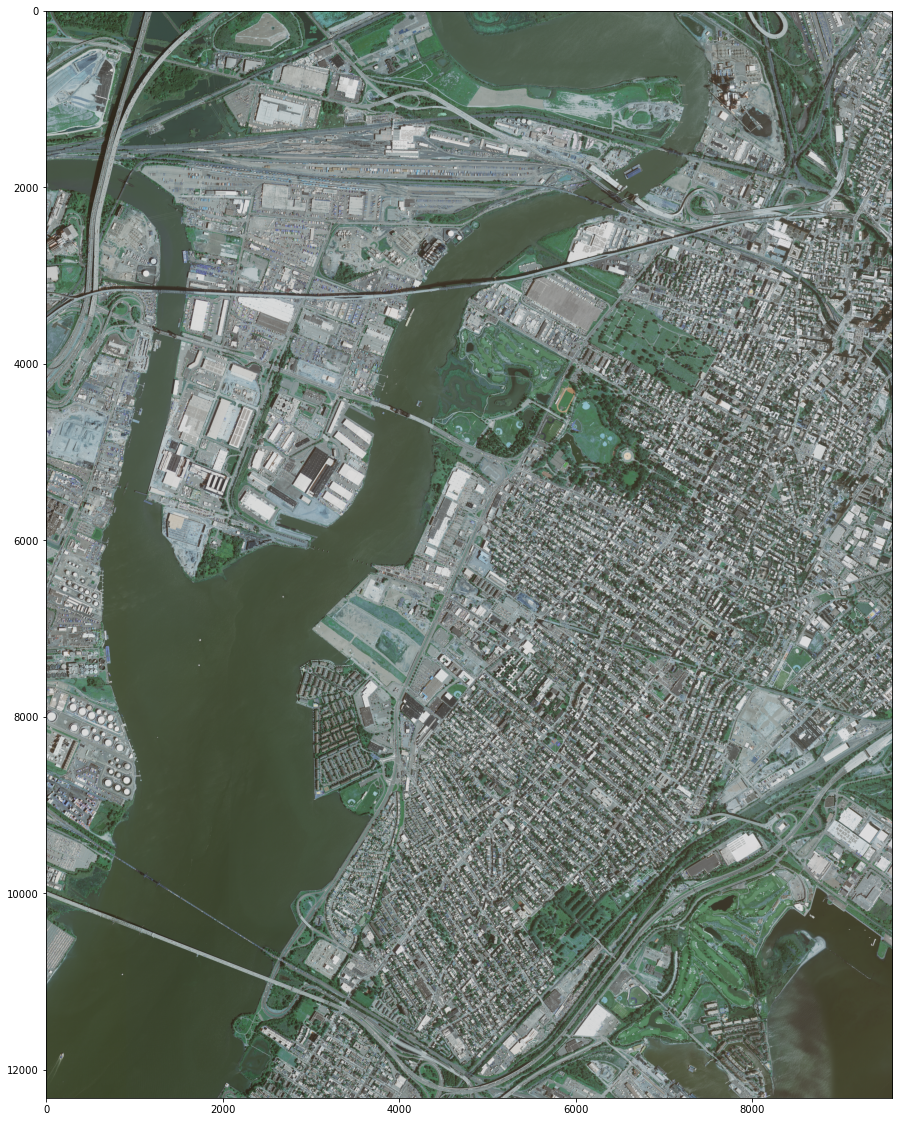

In [451]:
fig = plt.figure(figsize=(20, 20))
tile = cv.imread(os.path.join(tiles_complete_dataset_path,"m_4007424_nw_18_060_20190830.tif"))
plt.imshow(tile)
plt.show() 


NameError: name 'image_2_review_incorrect' is not defined

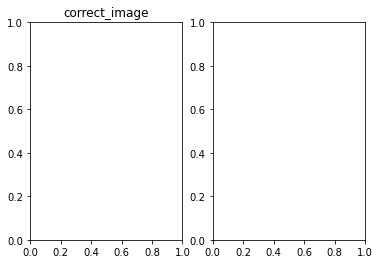

In [454]:
#temp_gray_incorrect_labeled_chip_image_unique_indices
#incorrect_labeled_chip_names_by_subfolder["incorrect_chip_paths"][temp_gray_incorrect_labeled_chip_image_unique_indices]
#gray_correctly_labeled_images_in_directory_array[0].shape
#os.path.join(correct_image_paths[0])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('correct_image')
ax1.imshow(cv.imread(image_2_review_incorrect[0]))
ax2.set_title('labeled_chip_array')
ax2.imshow(cv.imread(image_2_review_correct[0]))

In [394]:
cv.imread(os.path.join(tiles_complete_dataset_path,"m_3008824_ne_16_060_20191115.tif")).shape

(12310, 10750, 3)

In [396]:
12310/512
10750/512

20.99609375

In [26]:

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img)
#cv.imwrite('sift_keypoints.jpg',img)

In [30]:
len(kp)

5374

In [ ]:
(score, diff) = compare_ssim(gray_image, gray_tile)
diff = (diff * 255).astype("uint8")

In [ ]:
import cv2
img1 = cv2.imread('/content/det1.jpg', 0)
img2 = cv2.imread('/content/88.jpg', 0)
orb = cv2.ORB_create(nfeatures=500)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None)
cv2.imshow('original image', img1)
cv2.imshow('test image', img2)
cv2.imshow('Matches', match_img)
cv2.waitKey()

In [58]:
image1 = cv2.imread(os.path.join(parent_directory,
                "unverified_images\student_reviewed_unverified_images_set1\Alex\student_reviewed_images1\chips_positive",
                "al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg"),cv2.IMREAD_GRAYSCALE) # queryImage (img1)
image2 = cv2.imread(os.path.join(parent_directory,
                "unverified_images\student_reviewed_unverified_images_set1\Alex\student_reviewed_images1\chips_positive",
                "al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000444.jpg"),cv2.IMREAD_GRAYSCALE) # queryImage (img1)
#tile = cv2.imread('box_in_scene.png',gray_image) # trainImage(tile2)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_image1, des_image1 = sift.detectAndCompute(image1, None)
kp_image2, des_image2 = sift.detectAndCompute(image2, None)

In [59]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_image1, des_image2,k=2)

In [60]:
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

In [61]:
good

[[<DMatch 000001D517106130>],
 [<DMatch 000001D50E1DB830>],
 [<DMatch 000001D50E1DF4F0>],
 [<DMatch 000001D517412C30>],
 [<DMatch 000001D5174195B0>],
 [<DMatch 000001D51741E5B0>],
 [<DMatch 000001D51741E930>],
 [<DMatch 000001D51741F570>],
 [<DMatch 000001D51742E4F0>],
 [<DMatch 000001D517431170>],
 [<DMatch 000001D517432B30>],
 [<DMatch 000001D50CD6BEF0>],
 [<DMatch 000001D50E108AF0>],
 [<DMatch 000001D50E108E70>],
 [<DMatch 000001D50E10C470>],
 [<DMatch 000001D50E084C70>],
 [<DMatch 000001D50E0749F0>],
 [<DMatch 000001D50E07C130>],
 [<DMatch 000001D50E0981F0>],
 [<DMatch 000001D50E098AB0>],
 [<DMatch 000001D50D17E830>]]

In [64]:
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(des_image1, kp_image1, des_image2, kp_image1, good, None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\features2d\src\draw.cpp:127: error: (-2:Unspecified error) in function 'void __cdecl cv::_prepareImage(const class cv::_InputArray &,const class cv::Mat &)'
> Unsupported source image:
>     'src.type() == CV_8UC1 || src.type() == CV_8UC3 || src.type() == CV_8UC4'
> where
>     'src.type()' is 5 (CV_32FC1)


In [45]:
#bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_image, des_tile)
matches = sorted(matches, key=lambda x: x.distance)

In [65]:
incorrect_labeled_chip_names_by_subfolder = pd.read_csv("incorrect_labeled_chip_names_by_subfolder.csv")
incorrect_labeled_chip_image_array = np.zeros((len(incorrect_labeled_chip_names_by_subfolder),512,512, 3), dtype='uint8')
for num in tqdm.tqdm(range(len(incorrect_labeled_chip_names_by_subfolder))):    
    labeled_chip_array = cv2.imread(incorrect_labeled_chip_names_by_subfolder["incorrect_chip_paths"][num])  #open image
    incorrect_labeled_chip_image_array[num,:,:,:] = labeled_chip_array


### convert to incorrect_labeled_chip_image_array to gray scale
gray_incorrect_labeled_chip_image_array = np.empty((len(incorrect_labeled_chip_image_array), 512, 512),dtype='uint8')

for num in range(len(incorrect_labeled_chip_image_array)):
    gray_incorrect_labeled_chip_image_array[num,:,:]  = cv2.cvtColor(incorrect_labeled_chip_image_array[num,:,:,:],
                                                                     cv2.COLOR_BGR2GRAY)
    
gray_incorrect_labeled_chip_image_unique_array, gray_incorrect_labeled_chip_image_unique_indices = np.unique(gray_incorrect_labeled_chip_image_array, axis = 0, return_index=True)

100%|██████████| 2690/2690 [01:20<00:00, 33.24it/s]


In [80]:
means = np.mean(gray_incorrect_labeled_chip_image_unique_array,axis=(1,2))

In [78]:
len(means)
len(np.unique(means))

1350

In [ ]:
http://www.learningaboutelectronics.com/Articles/How-to-match-an-image-embedded-in-another-image-Python-OpenCV.php

In [ ]:
https://www.quora.com/What-algorithms-can-detect-if-two-images-objects-are-similar-or-not

In [ ]:
https://docs.opencv.org/2.4/modules/nonfree/doc/feature_detection.html?highlight=surf#feature-detection-and-description
https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html
https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [ ]:
https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/

In [23]:

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

'//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images\\student_reviewed_unverified_images_set1\\Alex\\student_reviewed_images1\\chips_positive\\al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg'

In [ ]:
m_3008808_sw_16_060_20191115

In [ ]:
fc.tile_to_chip_array(tile, 17, 0, 512)

#Make into module, function specify annotator, directory as args
#URG: updae tile_undone_npy

#!/usr/bin/env python
# coding: utf-8
import numpy as np
import pandas as pd
import os
import os.path
import urllib.request
import progressbar # pip install progressbar2, not progressbar

import os
import shutil

import argparse

import tempfile
import urllib
import shutil
import os
import os.path
import sys

import PIL
from PIL import Image

import math
import numpy as np
import pandas as pd
import rtree
import pickle

import progressbar # pip install progressbar2, not progressbar

from geopy.geocoders import Nominatim

from contextlib import suppress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import warnings
from zipfile import ZipFile

import data_eng.az_proc as ap
import data_eng.form_calcs as fc

In [11]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"

tile_names_tile_urls_complete_array = np.load("image_download_azure/tile_name_tile_url_complete_array.npy")

tiles_labeled = "tile_name_tile_url_labeled.npy"
tiles_labeled_from_complete_set = np.load(tiles_labeled)

tracker_file_path = 'outputs/tile_img_annotation_annotator.npy'
tile_img_annotation = np.load(tracker_file_path)

tiles_errors = 'tile_name_tile_url_error_downloading.npy'
tiles_errors = np.load(tiles_errors)

#create folder to hold tiles in completed dataset
path_to_complete_dataset = "verified/complete_dataset"
path_to_tiles_folder_complete_dataset = os.path.join(parent_directory, path_to_complete_dataset,"tiles")
path_positive_images_complete_dataset = os.path.join(parent_directory, path_to_complete_dataset,"chips_positive")
path_to_verified_sets = os.path.join(parent_directory, path_to_complete_dataset,"verified//verified_sets")

In [5]:
dist = ap.annotator("test") #create the processing class
dist.state_dcc_directory("C:\chip_allocation")

dist.number_of_tiles(2)

dist.get_tile_urls("temp_tile_name_tile_url.npy")

dist.make_subdirectories()
dist.download_images()
dist.tile_rename()
dist.chip_tiles()


Unlabeled Tiles (2, 2)
0
Bypassing download of already-downloaded file m_3208164_ne_17_060_20190829.tif
1
Bypassing download of already-downloaded file m_3208164_ne_17_060_20191109.tif
['https_naipeuwest.blob.core.windows.net_naip_v002_ga_2019_ga_60cm_2019_32081_m_3208164_ne_17_060_20191109.tif', 'https_naipeuwest.blob.core.windows.net_naip_v002_sc_2019_sc_60cm_2019_32081_m_3208164_ne_17_060_20190829.tif']
chip tiles
ga_60cm_2019_32081_m_3208164_ne_17_060_20191109.tif
505
sc_60cm_2019_32081_m_3208164_ne_17_060_20190829.tif
551


In [46]:
unique_positive_jpgs = fc.unique_positive_jpgs_from_parent_directory(parent_directory)
unique_positive_jpgs

(23531, 2)


array([['al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg'],
       ['al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000444.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000444.jpg'],
       ['al_60cm_2019_30088_m_3008816_se_16_060_20191115_000051.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008816_se_16_060_20191115_000051.jpg'],
       ...,
       ['wy_60cm_2019_44107_m_4410749_se_13_060_20190828_000460.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\wy_60cm_2019_44107_m_4410749_se_13_060_20190828_000460.jpg'],
       ['wy_60cm_2019_44108_m_4410801_ne_12_060_20190821_000041.jpg',
        '/

In [45]:
u, c = np.unique(unique_positive_jpgs[:,1], return_counts=True)
dup = u[c > 1]
len(dup)
#downloaded_tile

0

In [32]:
#Determine the corresponding tile names (formatted) for given paths of jpgs 
print(len(unique_positive_jpgs))
tile_names_formatted_storage_space = np.unique(fc.jpg_path_to_tile_name_formatted(unique_positive_jpgs[:,1]))
print(len(tile_names_formatted_storage_space))

23531
2077


In [33]:
#Deteremine the tile names (standard) for given paths of jpgs 
tile_names_standard_storage_space = []
for tile_name_formatted_storage_space in tile_names_formatted_storage_space:
    tile_names_standard_storage_space.append(tile_name_formatted_storage_space.split("_",4)[4])
    
#Create a 2d array of the standard and formatted tile names of the jpgs given
tile_names_in_storage_space_standard_formatted = np.hstack((np.array(tile_names_standard_storage_space)[:,None], tile_names_formatted_storage_space[:,None]))

In [55]:
u, c = np.unique(tile_names_in_storage_space_standard_formatted[:,0], return_counts=True)
dup = u[c > 1]
len(dup)
#downloaded_tile

np.sort(tile_names_in_storage_space_standard_formatted[np.isin(tile_names_in_storage_space_standard_formatted[:,0],dup)])

array(['m_3311822_ne_11_060_20180723', 'm_3708701_se_16_060_20180905',
       'm_3708701_sw_16_060_20180905', 'm_3708704_nw_16_060_20180725',
       'm_3708704_sw_16_060_20180725', 'm_3708711_ne_16_060_20180725',
       'm_3708712_nw_16_060_20180725', 'm_3708716_sw_16_060_20180929',
       'm_3712205_ne_10_060_20180723', 'm_3712205_se_10_060_20180723',
       'm_3712206_sw_10_060_20180723', 'm_3807730_se_18_060_20181025',
       'm_3808542_sw_16_060_20180727', 'm_3808543_ne_16_060_20180904',
       'm_3808549_se_16_060_20180727', 'm_3808550_nw_16_060_20180727',
       'm_3812262_se_10_060_20180723', 'm_3812263_sw_10_060_20180723',
       'm_3812264_se_10_060_20180715', 'm_3812264_sw_10_060_20180715',
       'm_4007423_se_18_060_20190830', 'm_4007423_sw_18_060_20190917',
       'm_4007424_sw_18_060_20190830', 'm_4007430_se_18_060_20190830',
       'm_4007431_nw_18_060_20190917', 'm_4007431_sw_18_060_20190917',
       'm_4009129_ne_15_060_20190708', 'm_4107114_nw_19_060_20180827',
      

In [40]:
u, c = np.unique(tile_names_in_storage_space_standard_formatted[:,1], return_counts=True)
dup = u[c > 1]
len(dup)

0

In [47]:
tile_names_in_storage_space_standard_formatted[:,1]

array(['al_60cm_2019_30088_m_3008808_sw_16_060_20191115',
       'al_60cm_2019_30088_m_3008816_se_16_060_20191115',
       'al_60cm_2019_30088_m_3008816_sw_16_060_20191115', ...,
       'wy_60cm_2019_44106_m_4410617_se_13_060_20190829',
       'wy_60cm_2019_44107_m_4410749_se_13_060_20190828',
       'wy_60cm_2019_44108_m_4410801_ne_12_060_20190821'], dtype='<U48')

In [ ]:
chips_positive_path = "C:/chip_allocation/complete_dataset/chips_positive"
unique_chips_positive_path = "C:/chip_allocation/complete_dataset/unique_chips_positive"
dups_chips_positive_path = "C:/chip_allocation/complete_dataset/dups_chips_positive"

images, imgsr, imgsg, imgsb = fc.positive_images_to_array(chips_positive_path)
unique_imgsr, duplicate_imgsr =fc.unique_by_first_dimension(imgsr, images)
unique_imgsg, duplicate_imgsg = fc.unique_by_first_dimension(imgsg, images)
unique_imgsb, duplicate_imgsb = fc.unique_by_first_dimension(imgsb, images)
unique_images = fc.intersection_of_sets(unique_imgsr, unique_imgsg, unique_imgsb)
duplicate_images = fc.intersection_of_sets(duplicate_imgsr, duplicate_imgsg, duplicate_imgsb)   

In [ ]:
fc.directory_tile_names(os.path.join(parent_directory,"unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive"),
                       'Qianyu 1 tile names')

fc.directory_tile_names("C:/chip_allocation/complete_dataset/dups_chips_positive",
                        'dup tile names')

fc.identify_all_paths_to_duplicate_images(parent_directory, duplicate_images)

pd.DataFrame(fc.sorted_list_of_files(dups_chips_positive_path), columns = ['chip_names']).to_csv('dups_chips_positive_path.csv') 

In [ ]:
folders = [  "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/complete_dataset/chips_positive",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_negative",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive"]

In [ ]:
Copy these tiles 
"la_60cm_2019_29093_m_2909310_sw_15_060_20190726"
From
"//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Alex/student_reviewed_images1/chips_negative"
To


In [ ]:
"//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//verified/verified_sets/verify_josh_jaewon_amadu_1/chips_positive"

In [70]:
for folder in folders:
    fc.remove_thumbs(folder)
    for jpg in os.listdir(folder):
        temp_jpg = os.path.splitext(jpg)[0].rsplit("_",1)[0]
        chip_number = os.path.splitext(jpg)[0].rsplit("_",1)[1]
        if (temp_jpg == "la_60cm_2019_29093_m_2909310_sw_15_060_20190726") & (jpg in duplicate_images):
            #pa_60cm_2019_39075_m_3907508_nw_18_060_20191015
            old_tile_path = os.path.join(folder, jpg)
            new_tile_path = os.path.join(folder, "pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".jpg")
            #la_60cm_2019_29093_m_2909310_sw_15_060_20190726
            
            if not os.path.exists(new_tile_path): 
                os.rename(old_tile_path, new_tile_path)
            if os.path.exists(new_tile_path) and os.path.exists(old_tile_path): #If the new tile path already exists, delete the old tile path (if it still exists)
                shutil.move(old_tile_path,
                            "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//duplicate_move/chips_positive/"+"pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".jpg")

In [5]:
folders = [  "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/complete_dataset/chips_positive_xml",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive_xml"]
for folder in folders:
    for xml in os.listdir(folder):
        temp_xml = os.path.splitext(xml)[0].rsplit("_",1)[0]
        print(temp_xml)
        chip_number = os.path.splitext(xml)[0].rsplit("_",1)[1]
        if (temp_xml == "la_60cm_2019_29093_m_2909310_sw_15_060_20190726") & (xml in duplicate_images):
            #pa_60cm_2019_39075_m_3907508_nw_18_060_20191015
            old_tile_path = os.path.join(folder, xml)
            new_tile_path = os.path.join(folder, "pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".xml")
            #la_60cm_2019_29093_m_2909310_sw_15_060_20190726
            
            #if not os.path.exists(new_tile_path): 
                #os.rename(old_tile_path, new_tile_path)
            #if os.path.exists(new_tile_path) and os.path.exists(old_tile_path): #If the new tile path already exists, delete the old tile path (if it still exists)
                #shutil.move(old_tile_path_xml,
                #            "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//duplicate_move/chips_positive_xml/"+"pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".xml")

co_60cm_2019_39104_m_3910410_se_13_060_20190912


NameError: name 'duplicate_images' is not defined

In [5]:
verified_positive_jpgs = fc.unique_positive_jpgs_from_parent_directory(os.path.join(parent_directory,"verified/complete_dataset/chips_positive"))
tiles_dir = tiles_complete_dataset_path

1it [00:02,  2.66s/it]

(19511, 2)


In [ ]:
verified_positive_jpgs 

SyntaxError: invalid syntax (Temp/ipykernel_10156/2107727356.py, line 3)

In [7]:
#image_characteristics.to_csv('image_characteristics.csv')
counterin = 0
counternot = 0 

#Check to see how many images are not yet in the image characteristics folder (not verified)
for unique_jpg in verified_positive_jpgs[:,0]:
    if image_characteristics['chip_name'].isin([unique_jpg]).any():
        counterin += 1
    if not image_characteristics['chip_name'].isin([unique_jpg]).any():
        counternot += 1
        print(unique_jpg)
print("images included in the image characteristics csv ",counterin, \
      "images not included in the image characteristics csv \ left to be verified", counternot)

m_3008144_nw_17_060_20191119_000525.jpg
m_3008824_ne_16_060_20191115_000532.jpg
m_3008824_ne_16_060_20191115_000533.jpg
m_3008824_ne_16_060_20191115_000557.jpg
m_3008824_ne_16_060_20191115_000558.jpg
m_3009147_se_15_060_20190906_000552.jpg
m_3311814_se_11_060_20180723_000506.jpg
m_3311814_se_11_060_20180723_000507.jpg
m_3311814_se_11_060_20180723_000508.jpg
m_3311814_se_11_060_20180723_000509.jpg
m_3311814_se_11_060_20180723_000510.jpg
m_3311814_se_11_060_20180723_000531.jpg
m_3311814_se_11_060_20180723_000533.jpg
m_3311814_se_11_060_20180723_000534.jpg
m_3311814_se_11_060_20180723_000535.jpg
m_3311814_sw_11_060_20180723_000510.jpg
m_3311814_sw_11_060_20180723_000511.jpg
m_3311814_sw_11_060_20180723_000515.jpg
m_3311814_sw_11_060_20180723_000516.jpg
m_3311814_sw_11_060_20180723_000517.jpg
m_3311814_sw_11_060_20180723_000518.jpg
m_3311814_sw_11_060_20180723_000536.jpg
m_3311814_sw_11_060_20180723_000539.jpg
m_3311814_sw_11_060_20180723_000540.jpg
m_3311814_sw_11_060_20180723_000541.jpg


In [ ]:
"m_3311814_ne_11_060_20180723.tif"